In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_CDDM(ub, lb, delta, ndt=0, z=0, sigma=1, dt=0.001):
    x = z
    
    rt = 0
    
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1
        
    return (rt+ndt)*ch

In [3]:
prms_speed = pd.read_csv('_prms/exp_speed.csv')
prms_accuracy = pd.read_csv('_prms/exp_accuracy.csv')
data = pd.read_csv('../../_Data/Study2.csv', 
                   index_col=0).reset_index(drop=True)

data = data.sort_values(by=['participant', 'trials', 'event'])

data = data[data['Duration']<data['RT']].reset_index(drop=True)

data['RT']/=1000
data['Duration']/=1000

data_speed = data[data.cue == 'SP'].reset_index(drop=True)
data_accuracy = data[data.cue == 'AC'].reset_index(drop=True)

In [4]:
prms_speed

,sbj,b0,lambda,delta,t0,sigma,mean_z,std_z,G2,BIC
0,processed_500Hz_0001_epo,0.617152,0.268713,0.168927,0.312410,0.213804,0.324868,0.071131,-139.194604,-116.640306
1,processed_500Hz_0002_epo,0.500000,0.189330,0.451577,0.288000,0.236351,0.281763,0.072092,-266.670639,-243.797084
2,processed_500Hz_0003_epo,0.576789,0.529080,0.615173,0.273051,0.202808,0.273314,0.054751,-245.886151,-223.614414
3,processed_500Hz_0004_epo,0.963477,0.972148,0.522725,0.338000,0.382519,0.330312,0.115571,-50.079470,-28.360442
4,processed_500Hz_0005_epo,0.627428,1.435497,0.193247,0.263000,0.247151,0.257511,0.051366,-269.636805,-247.250121
5,processed_500Hz_0006_epo,1.665229,2.745242,0.690246,0.266000,0.391589,0.261822,0.095003,-160.771794,-138.272746
6,processed_500Hz_0007_epo,0.540682,0.694176,0.386292,0.272473,0.331337,0.263404,0.076105,-220.709672,-197.993198
7,processed_500Hz_0008_epo,0.853328,0.477669,0.271763,0.274970,0.334060,0.279483,0.093112,-49.589279,-27.146097
8,processed_500Hz_0009_epo,0.594255,0.283983,0.326725,0.263647,0.291811,0.266567,0.072557,-152.558457,-129.684902
9,processed_500Hz_0010_epo,0.540770,0.041372,0.156689,0.301867,0.237166,0.311922,0.071245,-138.658441,-116.159393


In [5]:
RT = np.array([])
SBJ = np.array([])

for i in tqdm(range(prms_speed.sbj.unique().shape[0])):
    sbj = prms_speed.sbj.unique()[i]
    b0 = prms_speed['b0'].values[i]
    lamda = prms_speed['lambda'].values[i]
    delta = prms_speed['delta'].values[i]
    t0 = prms_speed['t0'].values[i]
    
    ub = lambda t: b0 * np.exp(-lamda*t)
    lb = lambda t: -1*ub(t) 
    
    sbj_data = data_speed[data_speed['participant']==sbj].reset_index(drop=True)
    
    rt = []
    
    for _ in range(100):
        rt.append(simulate_CDDM(ub, lb, delta, ndt=t0))
    
    RT = np.concatenate([RT, rt])
    SBJ = np.concatenate([SBJ, np.array([sbj]*len(rt))])
    
pred_speed = pd.DataFrame({'sbj': SBJ,
                           'rt': np.abs(RT),
                           'accuracy': RT>0})        

100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 14.78it/s]


In [6]:
RT = np.array([])
SBJ = np.array([])

for i in tqdm(range(prms_accuracy.sbj.unique().shape[0])):
    sbj = prms_accuracy.sbj.unique()[i]
    b0 = prms_accuracy['b0'].values[i]
    lamda = prms_accuracy['lambda'].values[i]
    delta = prms_accuracy['delta'].values[i]
    t0 = prms_accuracy['t0'].values[i]
    
    ub = lambda t: b0 * np.exp(-lamda*t)
    lb = lambda t: -1*ub(t) 
    
    sbj_data = data_accuracy[data_accuracy['participant']==sbj].reset_index(drop=True)
    
    rt = []
    
    for _ in range(100):
        rt.append(simulate_CDDM(ub, lb, delta, ndt=t0))
    
    RT = np.concatenate([RT, rt])
    SBJ = np.concatenate([SBJ, np.array([sbj]*len(rt))])
    
pred_accuracy = pd.DataFrame({'sbj': SBJ,
                              'rt': np.abs(RT),
                              'accuracy': RT>0})   

100%|███████████████████████████████████████████| 25/25 [00:02<00:00,  9.60it/s]


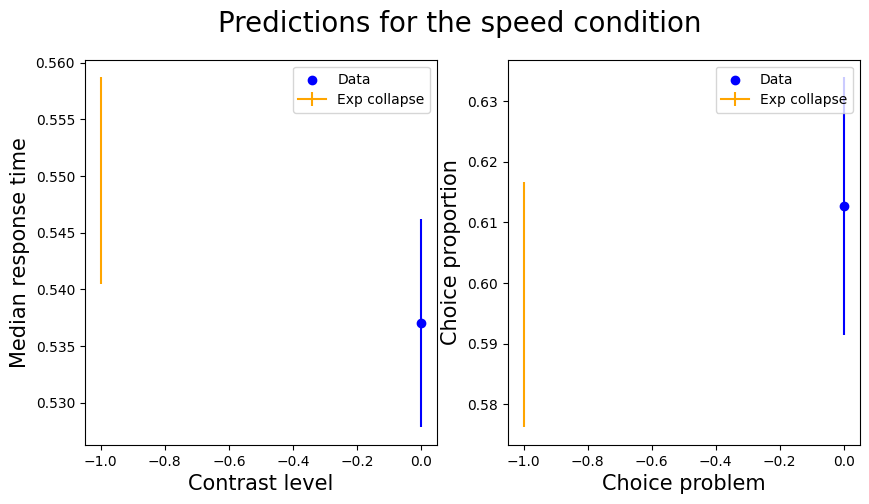

In [9]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Predictions for the speed condition', fontsize=20)

plt.subplot(121)

se = pred_speed['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_speed.shape[0])
plt.errorbar(x=-1, 
             y=pred_speed['rt'].median(),
             yerr=h, label='Exp collapse', c='orange');

se = data_speed['RT'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., data_speed.shape[0])
plt.errorbar(x=0, 
            y=data_speed['RT'].median(), 
            yerr=h, c='blue');
plt.scatter(x=0, 
            y=data_speed['RT'].median(), 
            c='blue', label='Data');
plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Median response time', fontsize=15)
plt.legend();

plt.subplot(122)
se = pred_speed['accuracy'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., 26)
plt.errorbar(x=-1, 
             y=pred_speed['accuracy'].mean(),
             yerr=h, label='Exp collapse', c='orange');

se = data_speed['correct'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., 26)
plt.errorbar(x=0, 
             y=data_speed['correct'].mean(), 
             yerr=h, c='blue');
plt.scatter(x=0, 
            y=data_speed['correct'].mean(), 
            c='blue', label='Data');
plt.xlabel('Choice problem', fontsize=15)
plt.ylabel('Choice proportion', fontsize=15)
plt.legend();

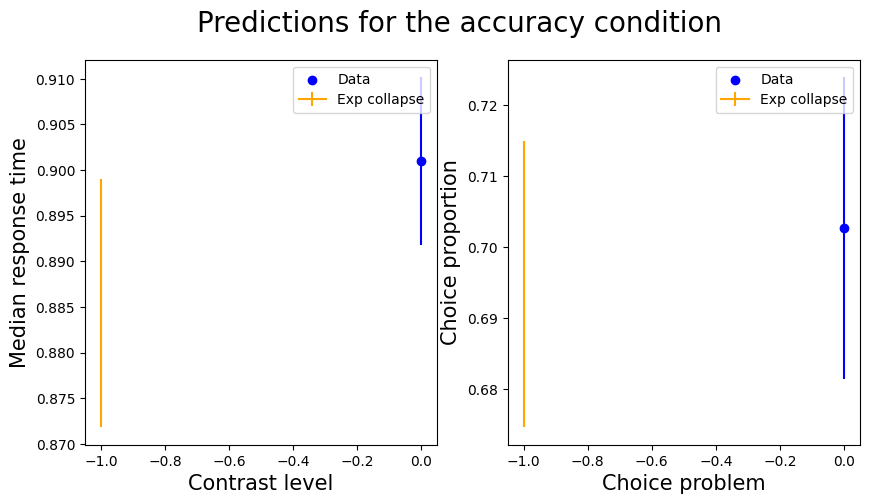

In [10]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Predictions for the accuracy condition', fontsize=20)

plt.subplot(121)

se = pred_accuracy['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_speed.shape[0])
plt.errorbar(x=-1, 
             y=pred_accuracy['rt'].median(),
             yerr=h, label='Exp collapse', c='orange');

se = data_speed['RT'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., data_accuracy.shape[0])
plt.errorbar(x=0, 
            y=data_accuracy['RT'].median(), 
            yerr=h, c='blue');
plt.scatter(x=0, 
            y=data_accuracy['RT'].median(), 
            c='blue', label='Data');
plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Median response time', fontsize=15)
plt.legend();

plt.subplot(122)
se = pred_speed['accuracy'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., 25)
plt.errorbar(x=-1, 
             y=pred_accuracy['accuracy'].mean(),
             yerr=h, label='Exp collapse', c='orange');

se = data_speed['correct'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., 25)
plt.errorbar(x=0, 
             y=data_accuracy['correct'].mean(), 
             yerr=h, c='blue');
plt.scatter(x=0, 
            y=data_accuracy['correct'].mean(), 
            c='blue', label='Data');
plt.xlabel('Choice problem', fontsize=15)
plt.ylabel('Choice proportion', fontsize=15)
plt.legend();

In [10]:
data['contrast'].min(), data['contrast'].max()

(3, 95)

In [12]:
prms_speed.describe()

,b0,lambda,delta,t0,sigma,mean_z,std_z,G2,BIC
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.721524,0.745099,0.403953,0.280513,0.303042,0.280069,0.079274,-167.192050,-144.766687
std,0.266061,0.692704,0.279723,0.034295,0.088706,0.036719,0.025340,78.767066,78.750319
min,0.500000,0.010000,0.012495,0.219000,0.112651,0.212122,0.032311,-289.242762,-266.913222
25%,0.552629,0.268713,0.235729,0.263647,0.247151,0.261822,0.061285,-220.709672,-197.993198
50%,0.604511,0.530245,0.332237,0.272473,0.291811,0.269893,0.072092,-185.745041,-162.975657
75%,0.816033,0.972148,0.446684,0.295287,0.382519,0.282817,0.095003,-138.664649,-116.159393
max,1.665229,2.745242,1.300727,0.389979,0.499756,0.374884,0.132672,24.126152,46.220355
